In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

plt.style.use('ggplot')
np.__version__

'1.23.5'

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Diseases/Symptom2Disease.csv')
df.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1200 non-null   int64 
 1   label       1200 non-null   object
 2   text        1200 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.2+ KB


In [ ]:
int2label = {}

for i, disease in enumerate(df['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

int2label, label2int

({0: 'Psoriasis',
  1: 'Varicose Veins',
  2: 'Typhoid',
  3: 'Chicken pox',
  4: 'Impetigo',
  5: 'Dengue',
  6: 'Fungal infection',
  7: 'Common Cold',
  8: 'Pneumonia',
  9: 'Dimorphic Hemorrhoids',
  10: 'Arthritis',
  11: 'Acne',
  12: 'Bronchial Asthma',
  13: 'Hypertension',
  14: 'Migraine',
  15: 'Cervical spondylosis',
  16: 'Jaundice',
  17: 'Malaria',
  18: 'urinary tract infection',
  19: 'allergy',
  20: 'gastroesophageal reflux disease',
  21: 'drug reaction',
  22: 'peptic ulcer disease',
  23: 'diabetes'},
 {'Psoriasis': 0,
  'Varicose Veins': 1,
  'Typhoid': 2,
  'Chicken pox': 3,
  'Impetigo': 4,
  'Dengue': 5,
  'Fungal infection': 6,
  'Common Cold': 7,
  'Pneumonia': 8,
  'Dimorphic Hemorrhoids': 9,
  'Arthritis': 10,
  'Acne': 11,
  'Bronchial Asthma': 12,
  'Hypertension': 13,
  'Migraine': 14,
  'Cervical spondylosis': 15,
  'Jaundice': 16,
  'Malaria': 17,
  'urinary tract infection': 18,
  'allergy': 19,
  'gastroesophageal reflux disease': 20,
  'drug reacti

Text(0.5, 1.0, 'Count of each disease')

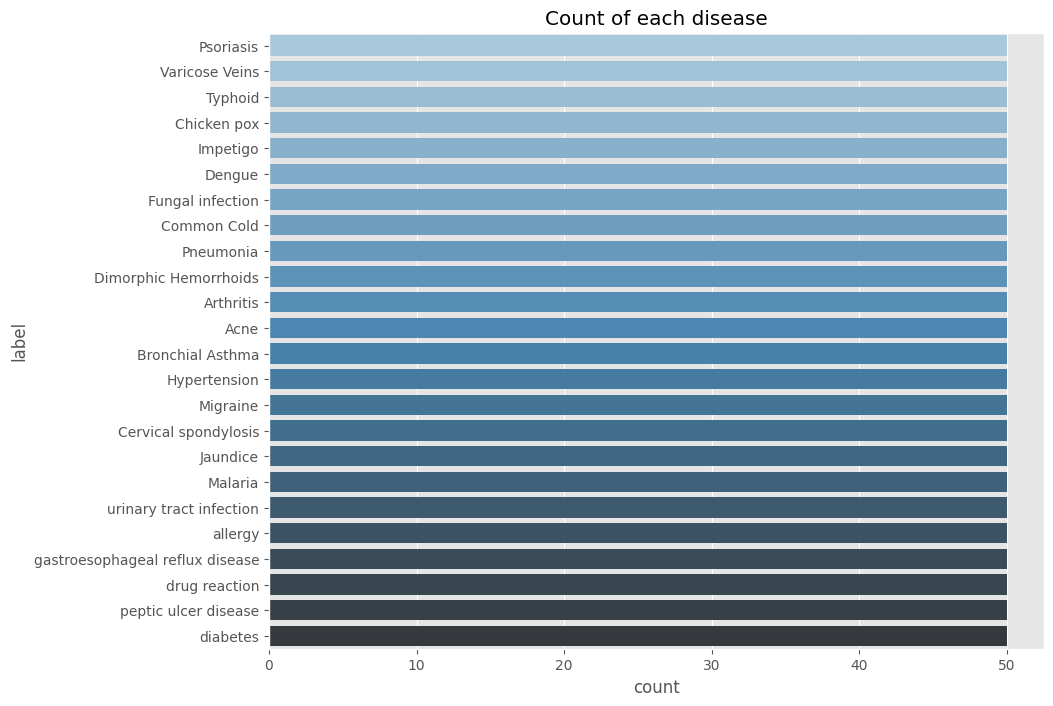

In [ ]:
plt.figure(figsize = (10, 8))

sea.countplot(y = df['label'], palette = 'Blues_d')
plt.title('Count of each disease')

  0%|          | 0/1200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of description length')

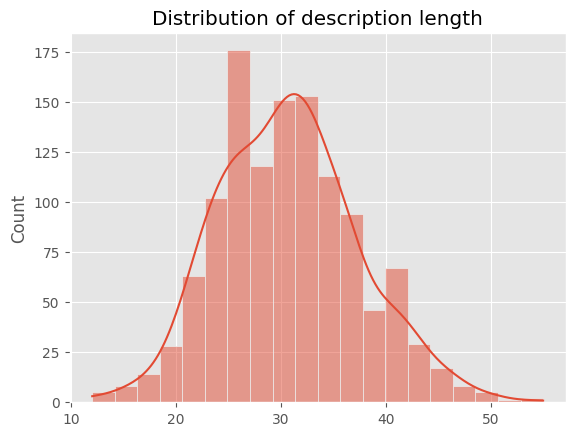

In [ ]:
length = []
for txt in tqdm(df['text'].values):
    length.append(len(txt.split()))

sea.histplot(length, kde = True, bins = 20)
plt.title('Distribution of description length')

In [ ]:
df['label'] = df['label'].map(lambda x : label2int[x])

In [ ]:
X, y = df['text'].values, df['label'].values

x_tokenizer = Tokenizer(filters = '')
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 2414


In [ ]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((1080,), (120,), (1080,), (120,))

In [ ]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)

In [ ]:
pip install keras --upgrade

In [ ]:
num_classes = 24

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = num_classes,
    id2label = int2label,
    label2id = label2int,
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['accuracy'])

model

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7cfd100156f0> True
<keras.src.layers.regularization.dropout.Dropout object at 0x7cfc6596c760> True
<keras.src.layers.core.dense.Dense object at 0x7cfc6596cb50> True


In [ ]:
EPOCHS = 3

history = model.fit(train_dataset,
          epochs = EPOCHS,
          validation_data = val_dataset)

In [ ]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()

In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k = num_classes)
pred1 = pipe("I am experiencing rashes on my skin. It is itchy and is now swelling. Even my sking is starting to peel. ")
pred2 = pipe("I have constipation and belly pain, and it's been really uncomfortable. The belly pain has been getting worse and is starting to affect my daily life. Moreover, I get chills every night, followed by a mild fever.")


print(pred1[0][:2])
print(pred2[0][:2])